# Drift-diffusion simulation of electrochemical doping

This notebook reproduces [published transient simulations](http://dx.doi.org/10.1063/1.4812236) of electrochemical doping.

Note that the simulation may not work for longer times than investigated in the paper because of the formation of an EDL which is poorly handled without further assumptions.

Also, all the profiles of electrical potential are inverted in the paper.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

from oedes import *
init_notebook()

## Model and parameters

The model is multilayer, with two layers: `electrolyte` and `pedot`. In `electrolyte`, cations and anions are allowed. In `pedot`, cations, anions and holes are simulated. 

In [2]:
electrolyte_mesh = fvm.mesh1d(
    25e-9,
    boundary_names=[
        'electrode0',
        'internal_boundary'])
pedot_mesh = fvm.mesh1d(
    175e-9,
    boundary_names=[
        'internal_boundary',
        'electrode1'])
mesh = fvm.multilayer1d(
    [('electrolyte', electrolyte_mesh), ('pedot', pedot_mesh)])
electrolyte_model = models.BaseModel()
electrolyte_model.name = 'electrolyte'
pedot_model = models.BaseModel()
pedot_model.name = 'pedot'
ions_electrolyte=models.add_ions(electrolyte_model,electrolyte_mesh)
ions_pedot=models.add_ions(pedot_model,pedot_mesh)
hole_eqn=models.add_transport(pedot_model,pedot_mesh,z=1,prefix='hole')

Doping of PEDOT:

In [3]:
pedot_model.additional_charge = [models.simple_doping]

BCs for Poisson's equation:

In [4]:
electrolyte_model.poisson.bc = [
    models.AppliedVoltage('electrode0'),
    models.Equal(
        pedot_model.poisson,
        'internal_boundary')]
pedot_model.poisson.bc = [models.AppliedVoltage('electrode1')]

BCs for holes and ions:

In [5]:
hole_eqn.bc = [models.DirichletFromParams('electrode1')]
for ion_electrolyte in ions_electrolyte:
    ion_electrolyte.bc = [models.DirichletFromParams('electrode0')]
for ion_pedot,ion_electrolyte in zip(ions_pedot,ions_electrolyte):
    ion_pedot.bc = [models.Equal(ion_electrolyte,'internal_boundary')]

Coupled model:

In [6]:
model = models.CompositeModel()
model.sub = [electrolyte_model, pedot_model]
model.other = [models.NewCurrentCalculation([electrolyte_model.poisson,pedot_model.poisson])]
model.setUp()

Parameters:

In [7]:
params = {
    'electrolyte.epsilon_r': 3.,
    'pedot.epsilon_r': 3,
    'electrolyte.T': 300,
    'pedot.T': 300,
    'electrolyte.electrode0.voltage': 0,
    'electrolyte.electrode0.workfunction': 0,
    'pedot.electrode1.voltage': 0,
    'pedot.electrode1.workfunction': 0,
    'pedot.hole.N0': 1e27,
    'pedot.hole.electrode1': 1e25,
    'pedot.hole.mu': 1e-7,
    'pedot.hole.level': 0,
    'pedot.Na': 1e25,
    'pedot.Nd': 0,
    'electrolyte.cation.electrode0': 1e25,
    'electrolyte.cation.mu': 1e-7,
    'electrolyte.cation.N0': 1e27,
    'electrolyte.cation.level': 0.,
    'electrolyte.anion.electrode0': 1e25,
    'electrolyte.anion.mu': 1e-7,
    'electrolyte.anion.N0': 1e27,
    'electrolyte.anion.level': 0.,
    'pedot.cation.mu': 1e-9,
    'pedot.cation.N0': 1e27,
    'pedot.cation.level': 0.,
    'pedot.anion.mu': 1e-9,
    'pedot.anion.N0': 1e27,
    'pedot.anion.level': 0.
}

In [8]:
def store(out):
    testing.store(out['electrolyte.potential'])
    testing.store(out['electrolyte.anion.c'], atol=1e12)
    testing.store(out['electrolyte.cation.c'], atol=1e12)
    testing.store(out['pedot.potential'], atol=1e12)
    testing.store(out['pedot.hole.c'], atol=1e12)
    testing.store(out['pedot.anion.c'], atol=1e12)
    testing.store(out['pedot.cation.c'], atol=1e12)

## Results

This example is not yet properly described. See the reference for details.

### Fig. 2

In [9]:
x = model.X.copy()
x[hole_eqn.idx] = params['pedot.Na']
c = context(model, x=x)
params['electrolyte.electrode0.voltage'] = 0.
params['pedot.electrode1.voltage'] = -1
c.transient(params, 1e-5, 1e-9)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [10]:
from oedes import mpl

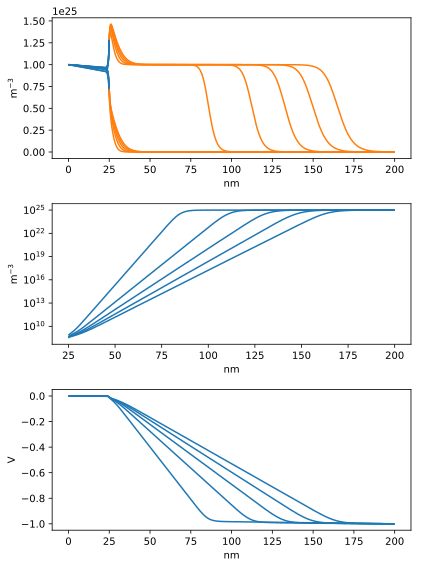

In [11]:
fig, (ion_plot, hole_plot, potential_plot) = plt.subplots(
    nrows=3, figsize=(6, 8))
for time in [2e-6, 4e-6, 6e-6, 8e-6, 10e-6]:
    ts = c.attime(time)
    store(ts.output())
    ts.mpl(fig, ion_plot).species('cation', settings=mpl.Settings.c_x_nm)
    ts.mpl(fig, ion_plot).species('anion', settings=mpl.Settings.c_x_nm)
    o = ts.output()
    ts.mpl(fig, hole_plot).species('hole')
    ts.mpl(fig, potential_plot).potential()
fig.tight_layout()

### Fig. 3

Text(0,0.5,'$\\ell^2$ [$nm%2$]')

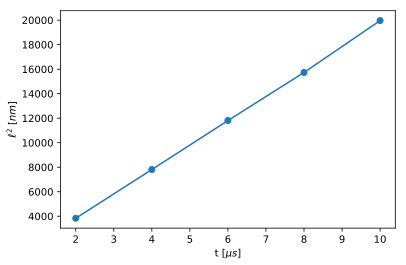

In [12]:
def length(out):
    store(out)
    c = out['pedot.hole.c']
    i = np.argwhere(c > 0.5e25)[0]
    return pedot_mesh.cells['center'][i] - pedot_mesh.cells['center'][0]


times = np.asarray([2e-6, 4e-6, 6e-6, 8e-6, 10e-6])
plt.plot(times * 1e6, [length(c.attime(t).output())
                       ** 2 * 1e18 for t in times], '-o')
plt.xlabel('t [$\mu s$]')
plt.ylabel('$\ell^2$ [$nm%2$]')

Text(0,0.5,'j [$A/cm^2$]')

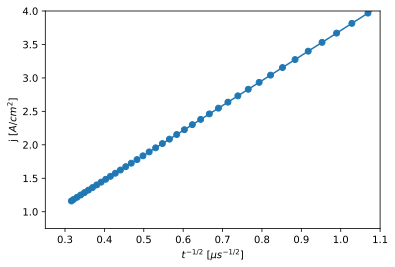

In [13]:
t, j = c.teval('time', 'electrode1.J')
t, j = t[t > 0], j[t > 0]
plt.plot(1. / np.sqrt(t * 1e6), j * 1e-4, 'o-')
plt.xlim([0.25, 1.1])
plt.ylim([0.75, 4])
plt.xlabel('$t^{-1/2}$ [$\mu s^{-1/2}$]')
plt.ylabel('j [$A/cm^2$]')

### Fig. 4

In [14]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
by_v = {}
voltages = [0.01, 0.05, 0.1, 0.5, 1]
for v in voltages:
    params['pedot.electrode1.voltage'] = -v
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_v[v] = c

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


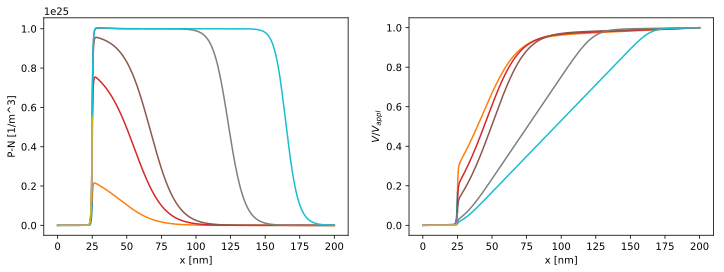

In [15]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
for v in voltages:
    o = by_v[v].attime(1e-5).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, o['electrolyte.potential'] / (-v))
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, o['pedot.potential'] / (-v))
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('$V/V_{appl}$')

### Fig. 5

In [16]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
params['pedot.electrode1.voltage'] = -1.
concentrations = [1e24, 1e25, 1e26]
by_c = {}
for conc in concentrations:
    params['electrolyte.cation.electrode0'] = conc
    params['electrolyte.anion.electrode0'] = conc
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_c[conc] = c

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


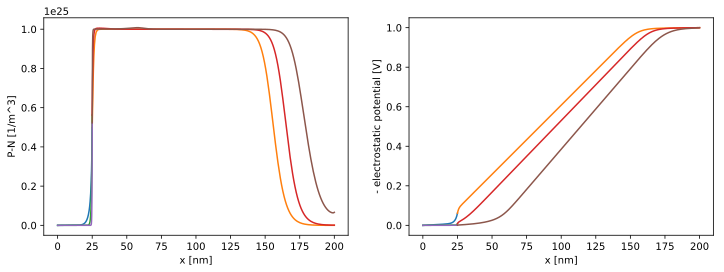

In [17]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
for conc in concentrations:
    o = by_c[conc].attime(1e-5).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, -o['electrolyte.potential'])
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, -o['pedot.potential'])
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('- electrostatic potential [V]')

### Fig. 6

In [18]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
params['pedot.electrode1.voltage'] = -1.
params['electrolyte.cation.electrode'] = 1e25
params['electrolyte.anion.electrode'] = 1e25
mu_values = [1e-10, 1e-9, 1e-8]
by_mu = {}
for mu in mu_values:
    params['pedot.cation.mu'] = mu
    params['pedot.anion.mu'] = mu
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_mu[mu] = c

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


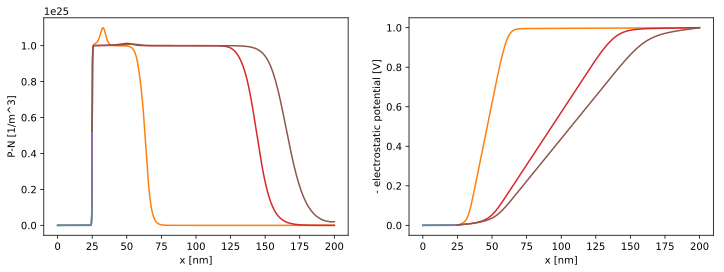

In [19]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
time = {1e-10: 6e-6, 1e-9: 6e-6, 1e-8: 1e-6}
for mu in mu_values:
    o = by_mu[mu].attime(time[mu]).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, -o['electrolyte.potential'] / v)
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, -o['pedot.potential'] / v)
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('- electrostatic potential [V]')

## Reference

Eleni Stavrinidou, Pierre Leleux, Harizo Rajaona, Michel Fiocchi, Sébastien Sanaur, George G. Malliaras [A simple model for ion injection and transport in conducting polymers](http://dx.doi.org/10.1063/1.4812236), Journal of Applied Physics 113, 244501 (2013).


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
